In [1]:
import sys
sys.path.append('../..')

from tqdm import tqdm
import argparse
import timm
import pickle as pkl
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import transforms, models
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Callback
from models.timm import TIMMModel
from models.flow_model import FlowModel, FreezeNetworkCallback
from models.flows import ConditionalNICE, ConditionalMAF
from torch import nn
from nflows.flows.autoregressive import MaskedAutoregressiveFlow
from data.augmentations import UpdateChancesBasedOnAccuracyCallback
import data.imagenet as ImageNet9

In [2]:
from pytorch_lightning.callbacks import Callback
import torch.nn as nn
PATH = '/home/macron/Praca Magisterska/Gotowe Sieci/flow_3ep_start_epclear_nolimit.pkl'

class AutopickleModel(Callback): #Thing that was helping with pickling is also messing up pickling, how delightful
    def __init__(self, model):
        self.model = model

    def on_validation_epoch_end(self, trainer, module):
        model_file = open(args.save_path, 'wb')
        # The base model should not need it anymore- and it's a bit messing up pickling
        self.model.base_model.train_dataloader = None
        self.model.base_model.val_dataloader = None
        self.model.base_model.trainer = None
        pkl.dump(self.model, model_file)
        model_file.close()

model_file = open(PATH, 'rb')
model = pkl.load(model_file)
model_file.close()
model.cuda()
flow = model.flow
backbone = nn.Sequential(model.base_model, model.embedding_model).cuda()

def create_flow(embedding_size=100):
    result = ConditionalMAF(embedding_size, hidden_features=256, num_layers=4, conditional_count=embedding_size, num_blocks_per_layer=4)
    result._epsilon = 1
    return result

def create_nonconditional_flow(embedding_size=100):
    result = MaskedAutoregressiveFlow(embedding_size, hidden_features=256, num_layers=4, num_blocks_per_layer=4)
    result._epsilon = 1
    return result

In [3]:
import torch
import torchvision.transforms.functional as TF
from data.shared import set_background

root_path = '/home/macron/Praca Magisterska/Kod/RobOptWUST/data/original/train'
foregrounds_path = '/home/macron/Praca Magisterska/Kod/RobOptWUST/data/only_fg/train'
backgrounds_path = '/home/macron/Praca Magisterska/Kod/RobOptWUST/data/only_bg_t/train'

def prepare_any_image(image):
    return TF.resize(TF.pil_to_tensor(image), (224, 224))/255.

def get_embedding(image):
    x = backbone(image[0].unsqueeze(0).cuda())
    return x[0].squeeze(0)

def prepare_image(foreground, background):
    image = set_background(foreground, TF.pil_to_tensor(background))
    return get_embedding(image)


In [4]:
from torch.utils.data import TensorDataset
def run_epoch(model, optimizer, dataloader, context):
    cumulative_loss = 0
    for x in dataloader:
        optimizer.zero_grad()
        loss = -model.log_prob(inputs=x[0], context=context.repeat(len(x[0]), 1) if context is not None else None).mean()
        loss.backward()
        optimizer.step()
        cumulative_loss += loss / len(x)
    return cumulative_loss

def train(embeddings, model, base_embedding, epoch_count=50):
    dataset = TensorDataset(embeddings)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
    epochs = tqdm(range(epoch_count))
    losses = []
    for i in epochs:
        loss = run_epoch(model, optimizer, dataloader, base_embedding)
        losses.append(loss)
        epochs.set_description(f'loss: {loss}')
    return model, losses

### One image learned flow

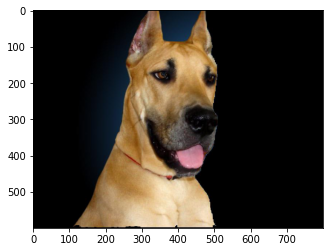

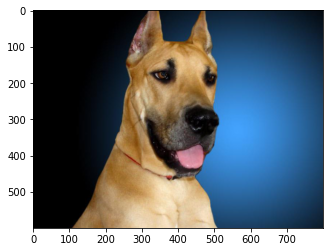

In [5]:
import os
import matplotlib.pyplot as plt
from data.shared import default_loader
from numpy.random import default_rng
from data.folder import IMG_EXTENSIONS, make_dataset

def find_classes(dir):
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

classes, class_to_idx = find_classes(root_path)

foregrounds = make_dataset(foregrounds_path, class_to_idx, IMG_EXTENSIONS)
backgrounds = make_dataset(backgrounds_path, class_to_idx, IMG_EXTENSIONS)

SAMPLES = 1000

rng = default_rng(42)
selected_foregrounds = rng.choice(foregrounds, size=1)

def get_base_image(image_type=None):
    path = selected_foregrounds[0][0]
    if image_type is not None:
        path = selected_foregrounds[0][0].replace(foregrounds_path, image_type)
    return default_loader(path)

foreground = get_base_image(None)
base_image = get_base_image(root_path)
plt.imshow(foreground)
plt.show()
plt.imshow(base_image)

In [6]:
embeddings, classes = torch.stack([prepare_image(foreground, default_loader(background[0])) for background in tqdm(backgrounds)]), [background[1] for background in backgrounds]

100%|█████████████████████████████████████| 45405/45405 [09:27<00:00, 79.94it/s]


In [7]:
base_embedding = get_embedding([prepare_any_image(base_image)])

In [8]:
flow = create_flow(128).cuda()
flow, c_losses = train(embeddings, flow, base_embedding)

loss: -468999.625: 100%|████████████████████████| 50/50 [08:34<00:00, 10.28s/it]


In [9]:
un_flow = create_nonconditional_flow(128).cuda()
un_flow, uc_losses = train(embeddings, un_flow, None)


loss: -454179.0625: 100%|███████████████████████| 50/50 [06:14<00:00,  7.49s/it]


In [34]:
bbun100_flow = create_nonconditional_flow(128).cuda()
bbun100_flow, bbuc100_losses = train(embeddings[0:100], bbun100_flow, None, epoch_count=400)

loss: -848.4271240234375: 100%|███████████████| 400/400 [00:09<00:00, 42.69it/s]


In [35]:
bbun10_flow = create_nonconditional_flow(128).cuda()
bbun10_flow, bbuc10_losses = train(embeddings[0:10], bbun10_flow, None, epoch_count=4000)

loss: -520.72216796875: 100%|███████████████| 4000/4000 [00:46<00:00, 86.95it/s]


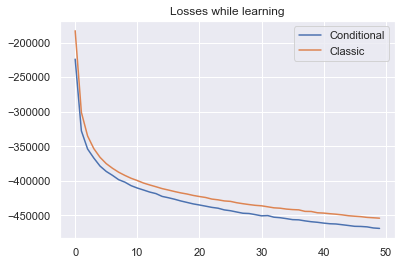

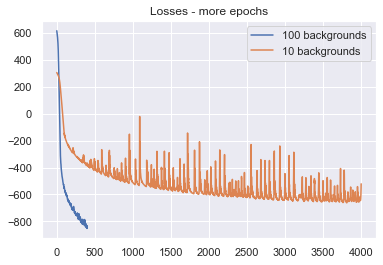

In [36]:
import seaborn as sns
import numpy as np
sns.set_theme(style="darkgrid")
def plot(tensor, label):
    np_tensor = np.array([t.cpu().detach() for t in tensor])
    plt.plot(np_tensor, label=label)

plt.title("Losses while learning")
plot(c_losses, label="Conditional")
plot(uc_losses, label="Classic")
plt.legend()
plt.show()
plt.title("Losses - more epochs")
plot(bbuc100_losses, label="100 backgrounds")
plot(bbuc10_losses, label="10 backgrounds")
plt.legend()
plt.show()

In [37]:
SAVE_DIR = '/home/macron/Praca Magisterska/Gotowe Sieci/'
def save_model(model, filename):
    model_file = open(SAVE_DIR + filename, 'wb')
    pkl.dump(model, model_file)
    model_file.close()
save_model(flow, 'conditional_all_backgrounds.pkl')
save_model(un_flow, 'classic_all_backgrounds.pkl')
save_model(bbun100_flow, 'classic_100_backgrounds.pkl')
save_model(bbun10_flow, 'classic_10_backgrounds.pkl')

In [45]:
def create_nice_flow(embedding_size=100):
    result = ConditionalNICE(embedding_size, hidden_sizes=[256, 256, 256], num_layers=4, conditional_count=embedding_size)
    result._epsilon = 1
    return result

loss: -390189.875: 100%|████████████████████████| 50/50 [03:45<00:00,  4.51s/it]


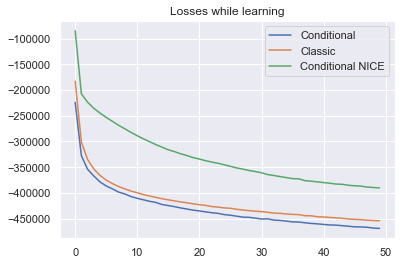

In [47]:
nice_flow = create_nice_flow(128).cuda()
nice_flow, nc_losses = train(embeddings, nice_flow, base_embedding)
save_model(nice_flow, 'nice_all_backgrounds.pkl')
plt.title("Losses while learning")
plot(c_losses, label="Conditional")
plot(uc_losses, label="Classic")
plot(nc_losses, label="Conditional NICE")
plt.legend()
plt.show()